# Team BTS 
Outpainting Project
By 

Bharath Gunasekaran

Stuti Agarwal

Tamanna Mehta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing the libraries
import cv2
import numpy as np
import random
import glob
import os
import imghdr
import itertools
import math
import json
from PIL import Image

import matplotlib.pyplot as plt
from keras.preprocessing.image import (ImageDataGenerator, array_to_img, img_to_array, load_img)
from keras.utils import generic_utils

import PIL
import keras
import keras.backend as K

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Flatten, Dropout, Activation, LeakyReLU, Reshape, Concatenate, Input
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, losses
from copy import deepcopy

from IPython.display import display, Image, Markdown, SVG
from keras.utils.vis_utils import model_to_dot

# Constants
IMAGE_SZ = 128
PADDING_WIDTH = int(IMAGE_SZ / 4)


In [ ]:
# Method to create discriminator layer that consits of Conv2d, dropout, and Batch normalization layer
def create_discrimator_layer(layer_input, filters, kernel_size = 5, strides = 2, padding = 'same', activation='leakyrelu', dropout_rate=0.25, norm=True,name='layer'):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, name=name+'conv2d')(layer_input)
    if activation == 'leakyrelu':
        conv = LeakyReLU(alpha=0.2,name=name+'leakyRelu')(conv)
    if dropout_rate:
        conv = Dropout(rate=dropout_rate,name=name+'dropRate')(conv)
    if norm:
        conv = BatchNormalization(name=name+'batch')(conv)
    return conv
    
# Defining Discriminator Model
def build_discriminator():
    discriminator_input = Input(shape=(IMAGE_SZ, IMAGE_SZ, 3))
    model = create_discrimator_layer(discriminator_input, 32, 5, norm=False,name='layer1')
    model = create_discrimator_layer(model, 64, 5, 2,name='layer2')
    model = create_discrimator_layer(model, 64, 5, 2,name='layer3')
    model = create_discrimator_layer(model, 64, 5, 2,name='layer4')
    model = create_discrimator_layer(model, 64, 5, 2,name='layer5')

    model = Flatten()(model)
    model = Dense(512, activation='relu')(model)
    discriminator_output = Dense(1, activation='sigmoid')(model)

    return Model(discriminator_input, discriminator_output)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
layer1conv2d (Conv2D)        (None, 64, 64, 32)        2432      
_________________________________________________________________
layer1leakyRelu (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
layer1dropRate (Dropout)     (None, 64, 64, 32)        0         
_________________________________________________________________
layer2conv2d (Conv2D)        (None, 32, 32, 64)        51264     
_________________________________________________________________
layer2leakyRelu (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
layer2dropRate (Dropout)     (None, 32, 32, 64)        0   

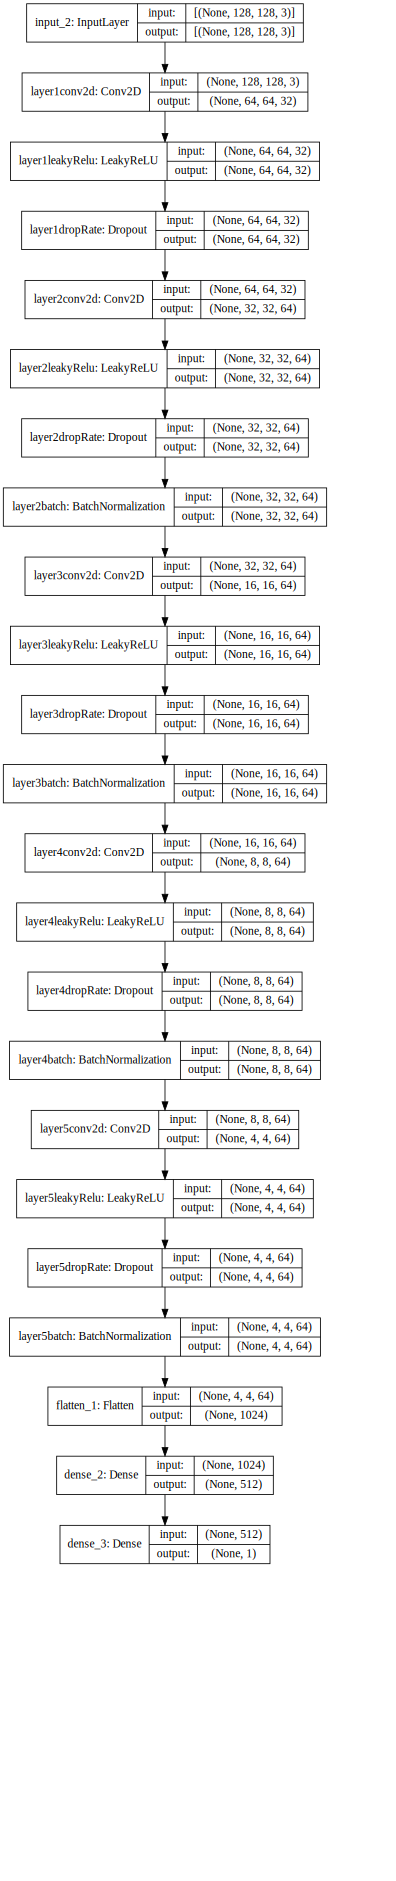

In [ ]:
# Creating the discriminator
discriminator = build_discriminator()
discriminator.trainable = False
discriminator.compile(loss = losses.MSE, optimizer = optimizers.Adam(lr=0.0001, beta_1=0.5))
discriminator.summary()

SVG(model_to_dot(discriminator, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

In [ ]:
#Method to create Generator layers -Encoder  
def generator_conv_layers(layer_input, filters, kernel_size, strides, padding='same', activation='relu', norm=True, dilation_rate=1):
    conv = Conv2D(filters, kernel_size=kernel_size, strides=strides, dilation_rate=(dilation_rate, dilation_rate), padding=padding)(layer_input)
    if activation=='relu':
        conv = Activation('relu')(conv)
    if norm:
        conv = BatchNormalization()(conv)
    return conv

#Method to create Generator layers-Decoder 
def generator_deconv_layers(layer_input, filters, kernel_size, strides, padding='same', activation='relu'):
    deconv = Conv2DTranspose(filters, kernel_size = kernel_size, strides = strides, padding = 'same')(layer_input)
    if activation == 'relu':
        deconv = Activation('relu')(deconv)
    return deconv
    
#Method to create Generator Model
def build_generator():
    generator_input = Input(shape=(IMAGE_SZ, IMAGE_SZ, 3))     
    ##### Encoder #####
    g1 = generator_conv_layers(generator_input, 64, 5, strides=1)
    g2 = generator_conv_layers(g1, 128, 3, strides=2)
    g3 = generator_conv_layers(g2, 256, 3, strides=1)

    # Dilated Convolutions
    g4 = generator_conv_layers(g3, 256, 3, strides=1, dilation_rate=2)
    g5 = generator_conv_layers(g4, 256, 3, strides=1, dilation_rate=4)
    g6 = generator_conv_layers(g5, 256, 3, strides=1, dilation_rate=8)
    g7 = generator_conv_layers(g6, 256, 3, strides=1)

    #### Decoder ####
    g8 = generator_deconv_layers(g7, 128, 4, strides=2)
    g9 = generator_conv_layers(g8, 64, 3, strides=1)
    
    generator_output = Conv2D(3, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', dilation_rate=(1,1))(g9)
    
    return Model(generator_input, generator_output)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512 

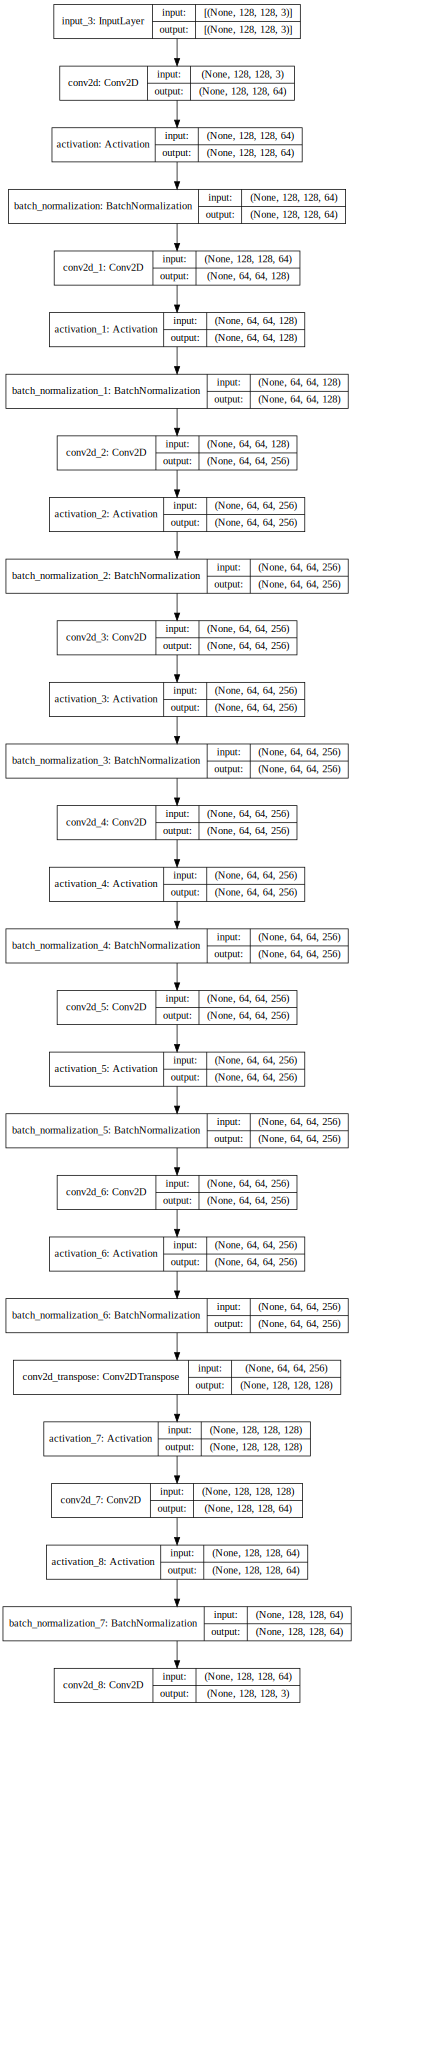

In [ ]:
# Creating the generator
generator = build_generator()
generator.compile(loss = 'mse', optimizer = optimizers.Adam(lr=0.0001, beta_1=0.5))
generator.summary()

SVG(model_to_dot(generator, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

In [ ]:
# Creating the GAN model
def build_gan():
    discriminator.trainable = False

    gan_input = Input(shape=(IMAGE_SZ, IMAGE_SZ, 3))      ## These are masked or Padded Images of shape 128x128 but the 0 to 32 and 96 to 128 will be masked
    generated_image = generator(gan_input)
    gan_output = discriminator(generated_image)
    
    gan = Model(gan_input,[generated_image, gan_output])
    return gan

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 128, 128, 3)       3340291   
_________________________________________________________________
model (Functional)           (None, 1)                 887425    
Total params: 4,227,716
Trainable params: 3,337,219
Non-trainable params: 890,497
_________________________________________________________________


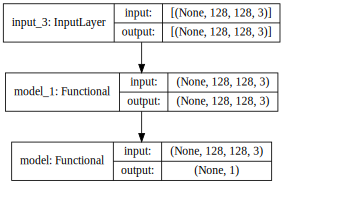

In [ ]:
gan = build_gan()
alpha=0.0004
gan.compile(loss = [losses.MSE, losses.MSE], optimizer = optimizers.Adam(lr=0.0001, beta_1=0.5), loss_weights = [1, alpha])
gan.summary()

SVG(model_to_dot(gan, show_layer_names=True, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

###Data Preprocessing on input dataset befor feeding to the model-
Crop and resize the Images, normalize them and mask out the boundary portion of the Images.

In [ ]:
'''
Converting the real images into masked images
'''
def get_masked_images(imgs, padding_width):
    padded_imgs = np.copy(imgs)
    pix_avg = np.mean(padded_imgs, axis=(1, 2, 3))
    print(pix_avg.shape)
    padded_imgs[:, :, :PADDING_WIDTH, :] = padded_imgs[:, :, -PADDING_WIDTH:, :] = pix_avg.reshape(-1, 1, 1, 1) #calculating mean pixel intensity and place it masked pixels
    padded_imgs[:, :PADDING_WIDTH, :, :] = padded_imgs[:, -PADDING_WIDTH:, :, :] = pix_avg.reshape(-1, 1, 1, 1) #calculating mean pixel intensty and place it masked pixelsi

    return padded_imgs
'''
Crop and resize the image
'''
def crop_and_resize_image(img, img_size):
    source_size = img.size
    if source_size == img_size:
        return img
    img = img.resize(img_size)
    return img
    
def renorm_image(img_norm):
    img_renorm = (img_norm * 255).astype(np.uint8)
    return img_renorm

In [ ]:
class DataGenerator(object):
    def __init__(self, root_dir, img_size= (128, 128), batch_size=32, padding_width= 32, validation_rate=0.1):
        self.batch_size = batch_size
        self.img_size = img_size
        self.padding_width = padding_width

        self.reset()
        self.img_file_list = [] 

        # Loading all the files at the provide path
        for root, dirs, files in os.walk(root_dir):
            for f in files[:100]:
                full_path = os.path.join(root, f)
                if imghdr.what(full_path) is None:
                    continue
                self.img_file_list.append(full_path)
                print(len(self.img_file_list))
        
        validation_size = math.floor(validation_rate*len(self.img_file_list)) #validation dataset size
        self.validation_file_list = self.img_file_list[:validation_size] #### shouldn't this be reverse???
        self.img_file_list = self.img_file_list[validation_size: ]

    def __len__(self):
        return len(self.img_file_list)

    def reset(self):
        self.images = []
        self.points = []
        self.masks = []

    def get_file_generator(self, file_list, shuffle=True):
        while True:
            if shuffle:
                np.random.shuffle(file_list)
            for f in file_list:
                img = crop_and_resize_image(load_img(f), self.img_size) # loading an image and resize
                self.images.append(img_to_array(img))

                if len(self.images) == self.batch_size: # creating a batch
                    imgs = (np.asarray(self.images, dtype=np.float32) / 255.0) # Normalizing the Images for an entire batch
                    self.reset()
                    yield get_masked_images(imgs, self.padding_width), imgs # returns both masked and actual images

    def flow(self):
        return self.get_file_generator(self.img_file_list) 

    def validation_flow(self, validation_steps=1):
        return self.get_file_generator(self.validation_file_list, shuffle=False)

In [ ]:
#Trainer Function for our model-3 phase training 
def train(path, data_generator, batch_size = 32, epochs = 1000, steps_per_epoch=None):
    input_shape = (128, 128, 3)
    padding_width = 32
   
    data_size = len(data_generator.img_file_list)
    print('data size: {}'.format(data_size))

    if steps_per_epoch is None:
        steps_per_epoch = data_size // batch_size

    t1_epochs = 50 # Epochs for the Generator
    t2_epcohs = 50 # Epochs for the Discriminator
    t3_epochs = 50 # Epochs for the GAN Model

    generator_history = {'loss': [], 'val_loss': []}
    discriminator_history = {'loss': [], 'val_loss': []}
    gan_history = {'loss': [], 'val_loss': []}

    print('Phase 1 - Training the Generator')
    generator_loss = generator.fit_generator(
        data_generator.flow(),
        epochs=t1_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=data_generator.validation_flow(), validation_steps=2)
    generator_history = generator_loss.history   

    print('Phase 2 - Training the Discriminator')
    counter = 0
    for current_epoch in range(t2_epcohs):
        print('Epoch {}/{}'.format(current_epoch, t2_epcohs))
        progressbar = generic_utils.Progbar(steps_per_epoch)
        for data in itertools.islice(data_generator.flow(), None, steps_per_epoch):
            masked_images, real_images = data
            fake_images = generator.predict(masked_images) 
            # Training on the Fake images & real images
            disc_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size, dtype='float32'))
            disc_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size, dtype='float32'))

            # Combining the losses from fake and real
            disc_loss = (disc_loss_real + disc_loss_fake)/2

            progressbar.add(1, values = [('Discriminator Loss', disc_loss)])

    print('Phase 3 - Training the GAN model')
    for current_epoch in range(t3_epochs):
        print('Epoch {}/{}'.format(current_epoch, t3_epochs))
        progressbar = generic_utils.Progbar(steps_per_epoch)
        for data in itertools.islice(data_generator.flow(), None, steps_per_epoch):
            masked_images, real_images = data
            fake_images = generator.predict(masked_images)
            # Training on the Fake images & real images
            disc_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size, dtype='float32'))
            disc_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size, dtype='float32'))

            # Combining the losses from fake and real

            disc_loss = (disc_loss_real + disc_loss_fake)/2
            # training GAN model
            gan_loss = gan.train_on_batch(masked_images, [real_images, np.ones((batch_size, 1), dtype='float32')])

            progressbar.add(1, values = [('Discriminator Loss', disc_loss), ('GAN Loss', gan_loss[0]), ('Generator Loss', gan_loss[1])])



In [ ]:
#loading the dataset
data_generator = DataGenerator('/content/drive/Shareddrives/CMPE-258/github_colabs/val_256', img_size=(128, 128), batch_size=32, padding_width=PADDING_WIDTH)


In [ ]:
len(data_generator.img_file_list)

90

In [ ]:
train('content/drive/Shareddrives/CMPE-258/github_colabs/val_256/',data_generator)

data size: 90
Phase 1 - Updating the Generator
(32,)
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


(32,)
2/2 [==============================] - ETA: 0s - loss: 0.1268 (32,)
(32,)
(32,)
2/2 [==============================] - 24s 2s/step - loss: 0.1253 - val_loss: 0.0965
Epoch 2/50
(32,)
2/2 [==============================] - ETA: 0s - loss: 0.0936(32,)
(32,)
(32,)
2/2 [==============================] - 2s 1s/step - loss: 0.0931 - val_loss: 0.0993
Epoch 3/50
(32,)
2/2 [==============================] - ETA: 0s - loss: 0.0813(32,)
(32,)
(32,)
2/2 [==============================] - 2s 1s/step - loss: 0.0807 - val_loss: 0.0950
Epoch 4/50
(32,)
2/2 [==============================] - ETA: 0s - loss: 0.0710(32,)
(32,)
(32,)
2/2 [==============================] - 2s 1s/step - loss: 0.0706 - val_loss: 0.0967
Epoch 5/50
(32,)
2/2 [==============================] - ETA: 0s - loss: 0.0632(32,)
(32,)
(32,)
2/2 [==============================] - 2s 1s/step - loss: 0.0634 - val_loss: 0.0971
Epoch 6/50
(32,)
2/2 [==============================] - ETA: 0s - loss: 0.0538(32,)
(32,)
(32,)
2/2 [========

In [ ]:
# method to load images
def load_images(in_PATH, verbose=False):
    imgs = []
    dirs = os.listdir( in_PATH )
    for item in dirs:
        print(in_PATH+item)
        print(os.path.isfile(in_PATH+item))
        if os.path.isfile(in_PATH+item):
            # im = load_city_image(path+item)
            im = PIL.Image.open(in_PATH+item).convert('RGB')
            # print(im.shape)
            pix=np.array(im)
            pix_norm = pix / 255.0
            imgs.append(pix_norm)
    return np.asarray(imgs)

In [ ]:
def createDataset(in_PATH):
    real = load_images(in_PATH)
    masked = get_masked_images(real,32)
    return masked,real

In [ ]:
masked,real = createDataset('/content/drive/Shareddrives/CMPE-258/github_colabs/train/')

/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000012.jpg
True
/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000014.jpg
True
/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000015.jpg
True
/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000013.jpg
True
/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000011.jpg
True
/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000010.jpg
True
/content/drive/Shareddrives/CMPE-258/github_colabs/train/Places365_val_00000009.jpg
True
(7,)


In [ ]:
masked[0].shape

(128, 128, 3)

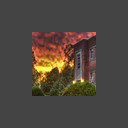

In [ ]:
img_norm = (masked[0] * 255.0).astype(np.uint8)
PIL.Image.fromarray(img_norm,'RGB')

(32,)


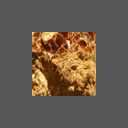

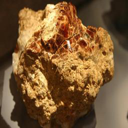

(32,)


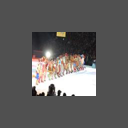

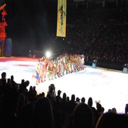

(32,)


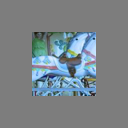

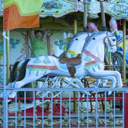

(32,)


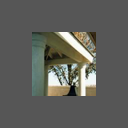

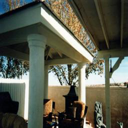

(32,)


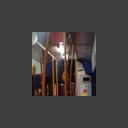

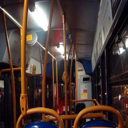

In [ ]:
for data in itertools.islice(data_generator.flow(), None, 5):
        masked_images, real_images = data
        fake_images = generator.predict(masked_images)
        img_norm = (masked_images[0] * 255.0).astype(np.uint8)
        display(PIL.Image.fromarray(img_norm,'RGB'))
        img_norm = (real_images[0] * 255.0).astype(np.uint8)
        display(PIL.Image.fromarray(img_norm,'RGB'))


In [ ]:
generated_image = generator.predict(masked)


In [ ]:
images = generator.predict(masked)

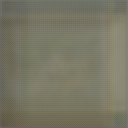

In [ ]:
img_norm = (images[0] * 255.0).astype(np.uint8)
PIL.Image.fromarray(img_norm,'RGB')